# Section 6.6.2 (figures of syllabus)
# Pumping tests, using Theis and Hantush wells

Pumping test data are provided for the tansient confined and semi-confined case and analyzed by different methods.

$$ s(r, t) = \frac Q {4 \pi kD} \mbox{W}(u),\,\,\,\, u = \frac {r^2 S} {4 kD t}$$

$$ s(r, t) = \frac Q {4 \pi kD} \mbox{W}_h(u, \frac r \lambda),\,\,\,\, u = \frac {r^2 S} {4 kD t}, \,\,\,\,\lambda=\sqrt{kD c}$$


where $\mbox{W}(..)$ is the so-called Theis well function, which is actually equal to the mathematical exponential integral

$$ \mbox{W}(u) = \mathtt{exp1}(z) = \intop _u ^\infty \frac {e^{-y}} {y} dy $$

and $\mbox{W}_h$ is Hantush well function

$$ \mbox{W}_h(u, \frac r \lambda) = \intop _u ^\infty \frac {e^{-y - \frac{\left(\frac r \lambda\right)^2}{y}}} {y} dy $$

The exponential integral lives in scipy special as the function $\mathtt{exp1}(z)$

dd

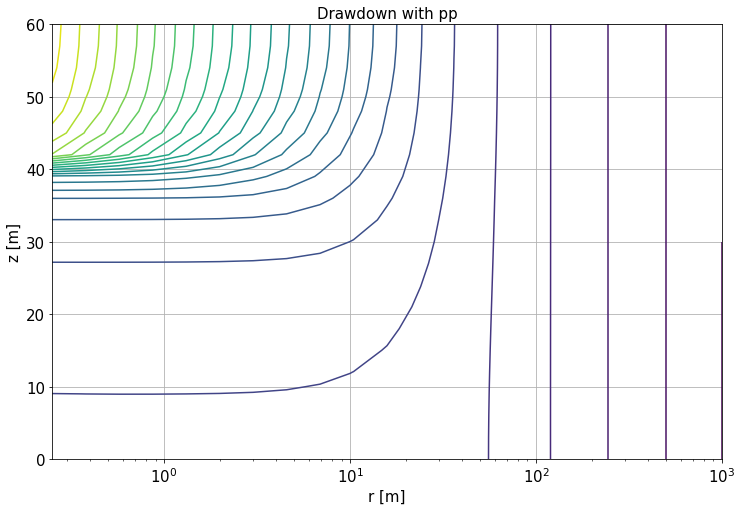

In [403]:
import numpy as np
from scipy.special import exp1, k0 as K0
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import pandas as pd
import pdb

attribs = lambda obj: [o for o in dir(obj) if not o.startswith('_')]

def newfig(title="title", xlabel="xlabel", ylabel="ylabel", xlim=None, ylim=None, xscale=None, yscale=None, size_inches=(12, 8),
           fontsize=15):
    fig, ax = plt.subplots()
    fig.set_size_inches(size_inches)
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    if xscale: ax.set_xscale(xscale)
    if yscale: ax.set_yscale(yscale)
    ax.tick_params(axis='both', labelsize=fontsize)
    ax.grid()
    return ax

def W(u):
    """Return Theis well function by integrating using scipy functionality.
    
    This turns out to be a very accurate yet fast impementation, about as fast
    as the exp1 function form scipy.special.
    """
    def kernel(y): return np.exp(-y)  / y
    def qd(u): return quad(kernel, u, np.inf)
    w = np.frompyfunc(qd, 1, 2)     
    return w(u)[0]

def Wh(u, rho):
    """Return Hantush well function by integration using scipy functinality.
    """
    def kernel(y, rho): return np.exp(-y - (rho/2) ** 2 / y ) / y    
    def qd(u, rho): return quad(kernel, u, np.inf, args=(rho))
    wh = np.frompyfunc(qd, 2, 2) # 2 inputs and tow outputs h and err
    return wh(u, rho)[0] # cut-off error info


def pp(z=None, r=None, ztop=None, zbot=None, D=None):
    """Return steady-state effect of partial penetration (still multiply by Q/(2 pi kD)).
    
    Parameters
    ----------
    z, r: np.arrays
        z and r coordinates with respect to bottom of the aquifer and heart line of the well.
        Make sure these arrays can be multiplied element by element
        so that broadcasting works.
    ztop: float
        z of top of screen from bottom of aquifer
    zbot: float
        z of bottom of screen from bottom of aquifer
    D: float
        aquifer thickness
    """
    rho  = np.pi * r  / D
    zeta = np.pi * z  / D
    etop = np.pi * ztop / D
    ebot = np.pi * zbot / D
    d = ztop - zbot
    delt = np.pi * d  / D
    PP = np.zeros((z * r ).shape)
    for n in range(1, 100):
        PP += 2 * (np.sin(n * etop) - np.sin(n * ebot)) * np.cos(n * zeta) * K0(n * rho) / (n * delt)
    return PP


def testPP(ztop=None, zbot=None, D=None, test=False):
    """Test partial penetration.
    
    Parameters
    ----------
    ztop, zbot: floats
        top and bottom elevation of screen relative to botto of aquifer
    D: float
        Thickness of the aquifer
    test: bool
        If True run the test and only show the contours
        if False only return the data.
    """
    k, R, Q, r0 = 15, 1000., 2400., 0.25 # m/d
    kD = D * k
    z = np.unique(np.hstack((np.linspace(0, D, 21), np.array([50, 10]))))
    r = np.unique(np.hstack((np.logspace(np.log10(r0), np.log10(R), 21), np.array([10, 30, 60, 120, 240]))))
    r, z = np.meshgrid(r, z)
    dd = Q / (2 * np.pi * kD) * np.log(R / r)
    dd += Q / (2 * np.pi * kD) * pp(z, r, ztop, zbot, D)
    
    if test:
        ax = newfig("Drawdown with pp", "r [m]", "z [m]", xscale='log')
        dd = testPP(60, 40, 60, False)
        ax.contour(r, z, dd, levels=25)
    else:
        return dd

testPP(60, 40, 60, True)

# Generate data for the given case

    Confined aquifer, D=60 m, k=30 m/d, c= 150 d, S = 0.0007
    Well pp = 20 m, r0 = 0.25
    Piezometers at 10 and 50 m below the top of the aquifer at 10, 30, 60, 120, 240 m
    Meaurements during 5 days
    Some correlated disturbances occurred

In [369]:
def t_measured():
    """Return measurement times."""
    t = [0.01, 0.03, 0.1, 0.3, 1, 2, 3 ,4, 5, 6, 7, 8, 9, 10] +\
        [15, 30, 45, 60, 90, 120, 150, 180, 240, 300, 360, 420, 480, 540, 600] + \
    list(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]) * 240)
    t = np.unique(np.array(t) / 24 / 60)
    return t

In [318]:
def get_noise(sigma1=0.03, sigma2=0.015, dtau=0.01, t=None,  full=False, npiezom=12):
    """Return autocorrelated white noisefor npiezom piezometers with fixed seeds.
    
    Parameters
    ----------
    sigma1: float
        sigma of basic noise, for all piezometers the same
    sigma2: float
        sigma for the noise that is different for each piezometer
    dtau: float
        time step for generating new noise
    t: nd.array
        times
    full: bool
        if True return the full noise vector.
        Else return the interpolated noise at the times in t only.
    npiezom: tuple with the dimensions of the piezometer set.
    """
    n = 1/ dtau
    N = int(t[-1] / dtau)
    tau = np.linspace(t[0], t[-1], N)
    np.random.seed(999)
    wn1 =  sigma1 * np.random.randn(N)
    noisesFull = np.zeros((npiezom, N))
    for i in range(npiezom):
        np.random.seed(i)
        wn2 = sigma2 * np.random.randn(N)
        b = np.exp(-7 / n * np.arange(n))
        noisesFull[i] = lfilter(b, 1, wn1) + lfilter(b, 1, wn2)
    if full:
        return noisesFull
    else:
        noisest = np.zeros((npiezom, len(t)))
        for i in range(npiezom):
            noisest[i] = np.interp(t, tau, noisesFull[i])
        return noisest

In [319]:
ztop, zbot, D, k, c, S = 60, 40, 60, 15, 150, 0.001
r0, r0_skinned = 0.25, 0.0125
Q, kD = 2400, k * D
z = np.array([10, 50]); nz = len(z)
r = np.array([r0_skinned, 10, 30, 60, 120, 240]); nr = len(r)
r, z = np.meshgrid(r, z)

t = t_meaured()

u = r[np.newaxis, :, :] **2 * S / (4 * kD * t[:, np.newaxis, np.newaxis])

dd = Q / (4 * np.pi * kD)  * (W(u) + 2 * pp(z=z, r=r, ztop=ztop, zbot=zbot, D=D))
dd[dd<0] = 0.

# Now that we have compute the drawdown replace r0_skinned by r0:
r[:, 0] = r0

if True:
    noises = get_noise(sigma1=0.02, sigma2=0.01, dtau=0.01, t=t,  full=False, npiezom=nz * nr).T
    noises = noises.reshape(len(t), nz, nr)
    for iz in range(nz):        
        for ir in range(nr):        
            dd[:, iz, ir] += noises[:, iz, ir]

columns = []
for iz in range(nz):
    for ir in range(nr):
        columns.append("p[{:.0f},{:.3g}]".format(z[iz,0], r[0, ir]))
        
# replace the radius in the first hdr text with the true well radius.
columns.pop(0)
columns = ["p[{:.0f},{:.3g}]".format(z[0,0], 0.25)] + columns
          
data = dd.astype(float).round(3).reshape((len(t), nz * nr))
data = pd.DataFrame(data, columns=columns, index=t)
data

,"p[10,0.25]","p[10,10]","p[10,30]","p[10,60]","p[10,120]","p[10,240]","p[50,0.25]","p[50,10]","p[50,30]","p[50,60]","p[50,120]","p[50,240]"
0.000007,0.020,0.019,-0.002,0.020,0.003,0.007,8.580,0.642,0.127,0.021,0.016,0.020
0.000021,0.020,0.019,-0.002,0.020,0.003,0.007,8.813,0.668,0.127,0.021,0.016,0.020
0.000069,0.020,0.019,-0.001,0.021,0.003,0.007,9.069,0.790,0.129,0.021,0.017,0.020
0.000208,0.021,0.019,-0.001,0.021,0.004,0.007,9.302,0.974,0.162,0.021,0.017,0.021
0.000694,0.135,0.123,0.051,0.028,0.005,0.009,9.560,1.211,0.294,0.046,0.019,0.022
0.001389,0.284,0.267,0.167,0.083,0.010,0.010,9.709,1.356,0.411,0.100,0.024,0.023
0.002083,0.372,0.353,0.243,0.133,0.021,0.012,9.798,1.442,0.488,0.150,0.035,0.025
0.002778,0.436,0.415,0.300,0.176,0.035,0.014,9.861,1.504,0.545,0.192,0.049,0.027
0.003472,0.485,0.463,0.345,0.212,0.050,0.016,9.911,1.552,0.592,0.228,0.064,0.029
0.004167,0.526,0.503,0.383,0.244,0.066,0.018,9.952,1.592,0.630,0.259,0.080,0.031


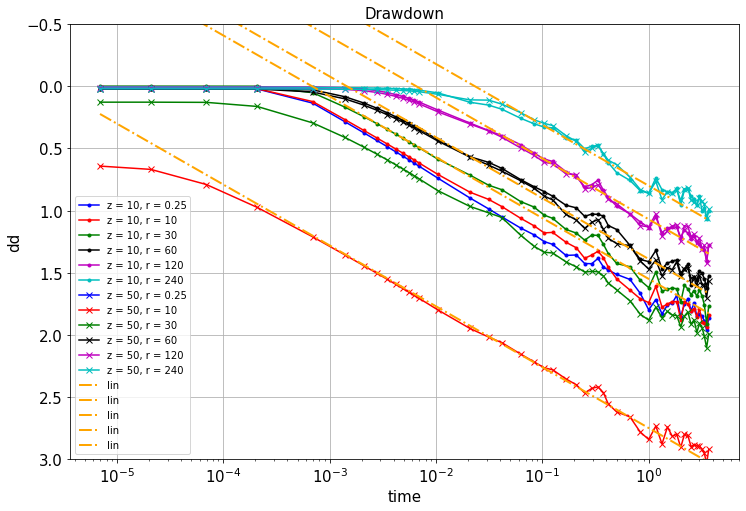

In [327]:
ax = newfig("Drawdown", "time", "dd", xscale='log', ylim=(3, -0.5))
for iz, z_ in enumerate(z[:, 0]):
    ls = ['.-','x-',':',';'][iz % 4]
    for ir, r_ in enumerate(r[0]):
        clr = 'brgkmcy'[ir % 7]        
        ax.plot(t, dd[:, iz, ir], ls, color=clr, label='z = {:.0f}, r = {:.4g}'.format(z_, r_))

a = 0.49
y0 = 1.55
y1 = 2.75 + a * np.log10(t)
y2 = 1.55 + a * np.log10(t)
y3 = 1.39 + a * np.log10(t)
y4 = 1.07 + a * np.log10(t)
y5 = 0.80 + a * np.log10(t)
ax.plot(t, y1, '-.', lw=2, color='orange', label="lin")
ax.plot(t, y2, '-.', lw=2, color='orange', label="lin")
ax.plot(t, y3, '-.', lw=2, color='orange', label="lin")
ax.plot(t, y4, '-.', lw=2, color='orange', label="lin")
ax.plot(t, y5, '-.', lw=2, color='orange', label="lin")

ax.legend()


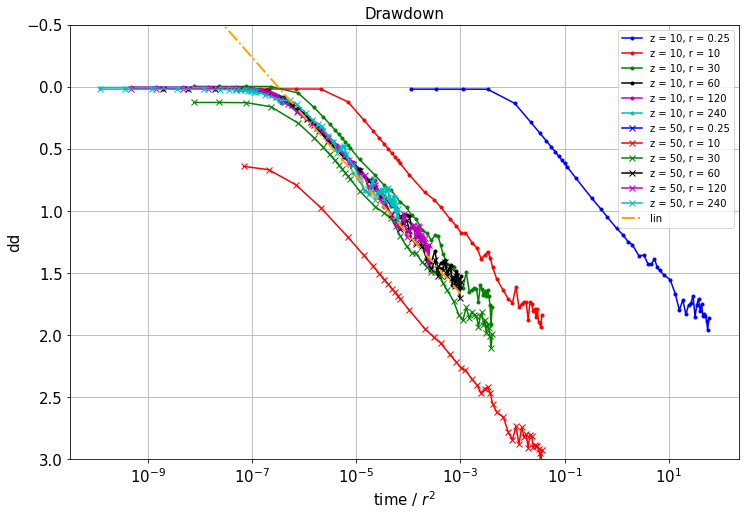

In [339]:
ax = newfig(r"Drawdown", "time / $r^2$", "dd", xscale='log', ylim=(3, -0.5))
for iz, z_ in enumerate(z[:, 0]):
    ls = ['.-','x-',':',';'][iz % 4]
    for ir, r_ in enumerate(r[0]):
        clr = 'brgkmcy'[ir % 7]        
        ax.plot(t / r_ ** 2, dd[:, iz, ir], ls, color=clr, label='z = {:.0f}, r = {:.4g}'.format(z_, r_))

a = 0.475
y1 = 1.4 + a * np.log10(t)
ax.plot(t/60 ** 2, y1, '-.', lw=2, color='orange', label="lin")

ax.legend()

# Growing radius of influence

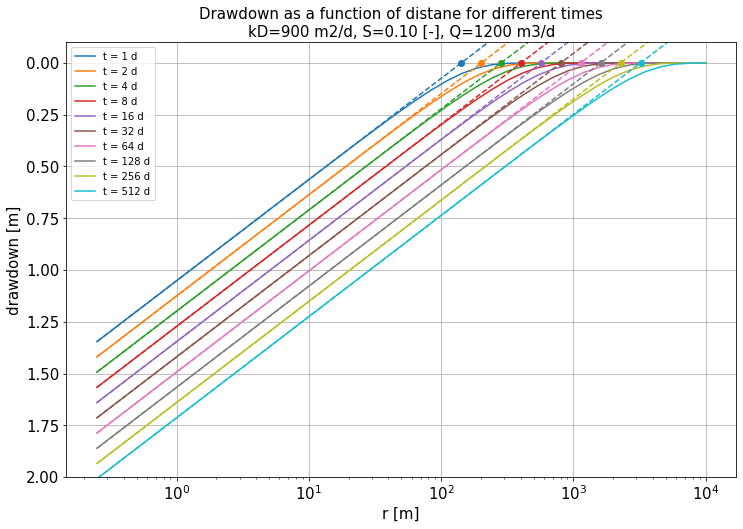

In [361]:
kD = 900 # m2/d
S = 0.1 # [-]
Q = 1200 # m3/d
ttl = "kD={:.0f} m2/d, S={:.2f} [-], Q={:.0f} m3/d".format(kD, S, Q)
ax = newfig("Drawdown as a function of distane for different times\n" + ttl, "r [m]", "drawdown [m]",
            xscale='log', ylim=(2, -0.1))

times = 2 ** np.arange(10)
r = np.logspace(np.log10(0.25), 4, 41)

for t in times:
    u = r ** 2 * S / (4 * kD * t)
    dd = Q / (4 * np.pi * kD) * W(u)
    
    ddlog = Q / (4 * np.pi * kD) * np.log(2.25 * kD * t  / (r ** 2 * S))
    line, = ax.plot(r, dd, label='t = {:.4g} d'.format(t))
    color = line.get_color()
    ax.plot(r, ddlog, '--', color=color)
    ax.plot(np.sqrt(2.25 * kD * t / S), 0, 'o', color=color)
ax.legend()

# Classic pumping test analysis

In [394]:
# Get the data (generate them) and put the data in a pd.DataFrame

ztop, zbot, D, k, c, S = 60, 40, 60, 15, 150, 0.001
r0, r0_skinned = 0.25, 0.0125
Q, kD, lamb = 2400, k * D, np.sqrt(k * D * c)
z = np.array([10, 50]); nz = len(z)
r = np.array([r0_skinned, 10, 30, 60, 120, 240]); nr = len(r)
r, z = np.meshgrid(r, z)

t = t_measured()

u = r **2 * S / (4 * kD * t[:, np.newaxis, np.newaxis])

dd = Q / (4 * np.pi * kD)  * (Wh(u, r/lamb) + 2 * pp(z=z, r=r, ztop=ztop, zbot=zbot, D=D))
dd[dd<0] = 0.

# Now that we have compute the drawdown replace r0_skinned by r0:
r[:, 0] = r0

if True:
    noises = get_noise(sigma1=0.02, sigma2=0.01, dtau=0.01, t=t,  full=False, npiezom=nz * nr).T
    noises = noises.reshape(len(t), nz, nr)
    for iz in range(nz):        
        for ir in range(nr):        
            dd[:, iz, ir] += noises[:, iz, ir]

columns = []
for iz in range(nz):
    for ir in range(nr):
        columns.append("p[{:.0f},{:.3g}]".format(z[iz,0], r[0, ir]))
        
# replace the radius in the first hdr text with the true well radius.
columns.pop(0)
columns = ["p[{:.0f},{:.3g}]".format(z[0,0], 0.25)] + columns
          
data = dd.astype(float).round(3).reshape((len(t), nz * nr))
data = pd.DataFrame(data, columns=columns, index=t)
data

,"p[10,0.25]","p[10,10]","p[10,30]","p[10,60]","p[10,120]","p[10,240]","p[50,0.25]","p[50,10]","p[50,30]","p[50,60]","p[50,120]","p[50,240]"
0.000007,0.020,0.019,-0.002,0.020,0.003,0.007,8.580,0.642,0.127,0.021,0.016,0.020
0.000021,0.020,0.019,-0.002,0.020,0.003,0.007,8.813,0.668,0.127,0.021,0.016,0.020
0.000069,0.020,0.019,-0.001,0.021,0.003,0.007,9.069,0.790,0.129,0.021,0.017,0.020
0.000208,0.021,0.019,-0.001,0.021,0.004,0.007,9.302,0.974,0.162,0.021,0.017,0.021
0.000694,0.134,0.122,0.051,0.028,0.005,0.009,9.559,1.211,0.294,0.046,0.019,0.022
0.001389,0.282,0.265,0.166,0.083,0.010,0.010,9.707,1.354,0.409,0.100,0.024,0.023
0.002083,0.369,0.350,0.241,0.132,0.021,0.012,9.795,1.439,0.486,0.149,0.035,0.025
0.002778,0.432,0.411,0.297,0.174,0.034,0.014,9.857,1.500,0.542,0.190,0.049,0.027
0.003472,0.480,0.459,0.342,0.210,0.050,0.016,9.906,1.548,0.588,0.226,0.064,0.029
0.004167,0.520,0.497,0.379,0.241,0.065,0.018,9.946,1.587,0.626,0.256,0.079,0.031


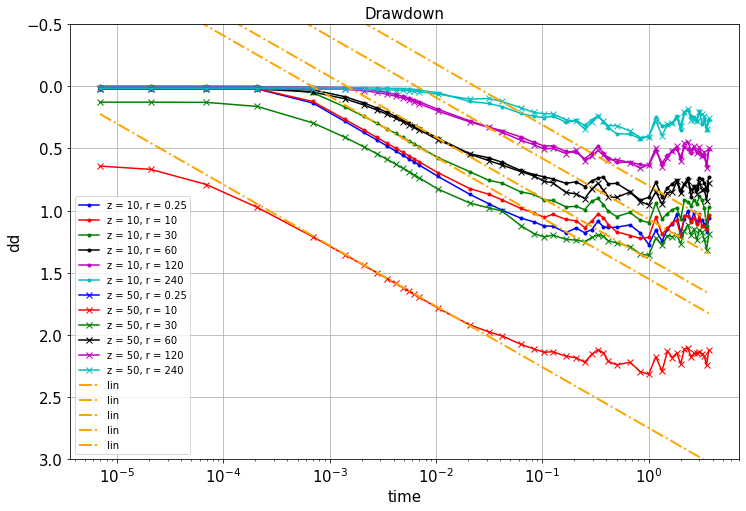

In [395]:
ax = newfig("Drawdown", "time", "dd", xscale='log', ylim=(3, -0.5))
for iz, z_ in enumerate(z[:, 0]):
    ls = ['.-','x-',':',';'][iz % 4]
    for ir, r_ in enumerate(r[0]):
        clr = 'brgkmcy'[ir % 7]        
        ax.plot(t, dd[:, iz, ir], ls, color=clr, label='z = {:.0f}, r = {:.4g}'.format(z_, r_))

a = 0.49
y0 = 1.55
y1 = 2.75 + a * np.log10(t)
y2 = 1.55 + a * np.log10(t)
y3 = 1.39 + a * np.log10(t)
y4 = 1.07 + a * np.log10(t)
y5 = 0.80 + a * np.log10(t)
ax.plot(t, y1, '-.', lw=2, color='orange', label="lin")
ax.plot(t, y2, '-.', lw=2, color='orange', label="lin")
ax.plot(t, y3, '-.', lw=2, color='orange', label="lin")
ax.plot(t, y4, '-.', lw=2, color='orange', label="lin")
ax.plot(t, y5, '-.', lw=2, color='orange', label="lin")

ax.legend()


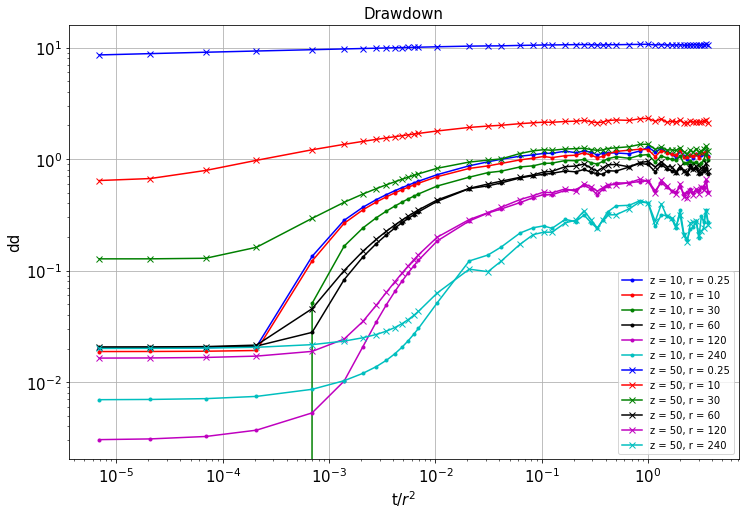

In [465]:
ax = newfig("Drawdown", r"t/$r^2$", "dd", xscale='log', yscale='log')
for iz, z_ in enumerate(z[:, 0]):
    ls = ['.-','x-',':',';'][iz % 4]
    for ir, r_ in enumerate(r[0]):
        clr = 'brgkmcy'[ir % 7]        
        ax.plot(t, dd[:, iz, ir], ls, color=clr, label='z = {:.0f}, r = {:.4g}'.format(z_, r_))
ax.legend()


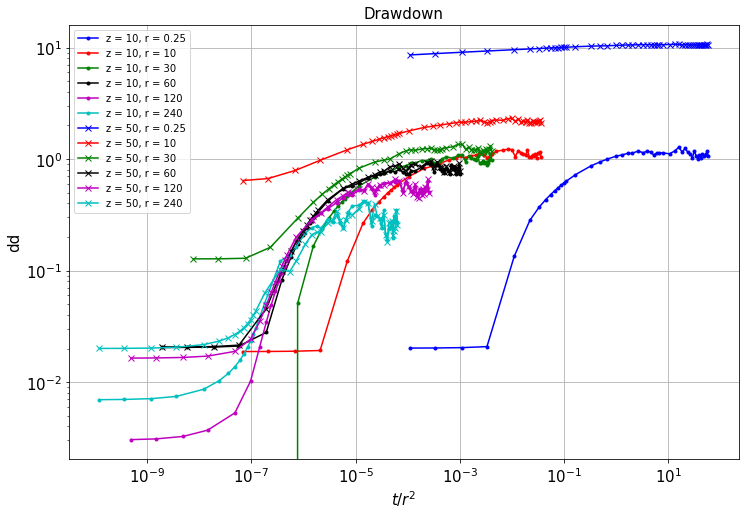

In [466]:
ax = newfig("Drawdown", r"$t/r^2$", "dd", xscale='log', yscale='log')
for iz, z_ in enumerate(z[:, 0]):
    ls = ['.-','x-',':',';'][iz % 4]
    for ir, r_ in enumerate(r[0]):
        clr = 'brgkmcy'[ir % 7]        
        ax.plot(t / r_ ** 2, dd[:, iz, ir], ls, color=clr, label='z = {:.0f}, r = {:.4g}'.format(z_, r_))
ax.legend()

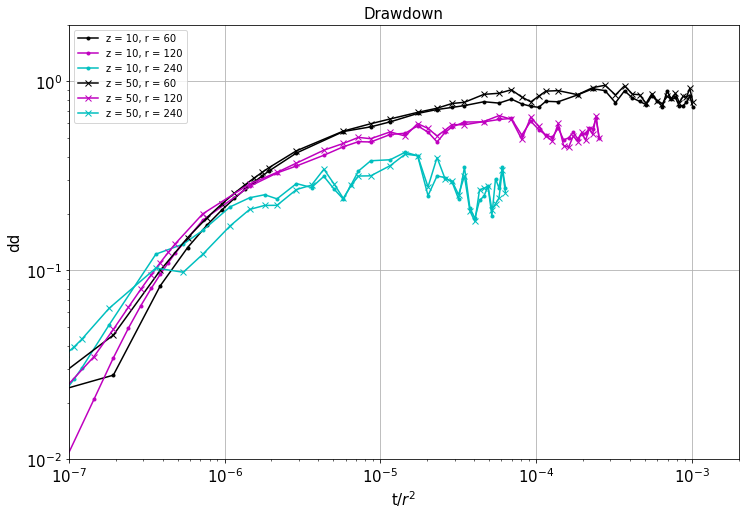

In [518]:
ax = newfig("Drawdown", r"t/$r^2$", "dd", xscale='log', yscale='log', xlim=(1e-7, 2e-3), ylim=(1e-2, 2))
for iz, z_ in enumerate(z[:, 0]):
    ls = ['.-','x-',':',';'][iz % 4]
    for ir, r_ in enumerate(r[0]):
        if r_ >= 60:
            clr = 'brgkmcy'[ir % 7]        
            ax.plot(t / r_ ** 2, dd[:, iz, ir], ls, color=clr, label='z = {:.0f}, r = {:.4g}'.format(z_, r_))
ax.legend()
fig=ax.figure

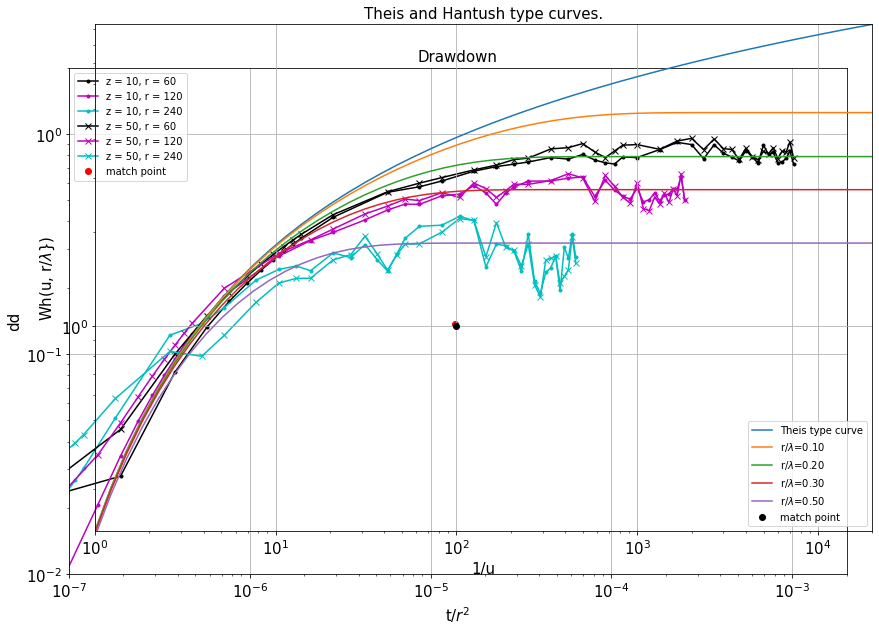

In [517]:
ax = newfig("Drawdown", r"t/$r^2$", "dd", xscale='log', yscale='log', xlim=(1e-7, 2e-3), ylim=(1e-2, 2))
for iz, z_ in enumerate(z[:, 0]):
    ls = ['.-','x-',':',';'][iz % 4]
    for ir, r_ in enumerate(r[0]):
        if r_ >= 60:
            clr = 'brgkmcy'[ir % 7]        
            ax.plot(t / r_ ** 2, dd[:, iz, ir], ls, color=clr, label='z = {:.0f}, r = {:.4g}'.format(z_, r_))
ax.plot(1.37e-5, 1.37e-1, 'ro', label='match point')
ax.legend()
fig=ax.figure


u = np.logspace(np.log10(1e-4/2), 0.0)
if False:
    A = 0.00000027
    B = 0.2
    ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    ax1.patch.set_color("none")
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.grid()
    ax1.plot(A * 1/u, B * W(u), 'g', lw=3, label="Theis type curve")
else:
    pos1 = (0.155, 0.2, 0.9, 0.88)
    pos2 = (0.125, 0.125, 0.9, 0.88)
    
    ax1 = fig.add_axes(pos1)
    ax1.set_position(pos1)
    ax.set_position( pos2)
    ax1.set_title("Theis and Hantush type curves.", fontsize=15)
    ax1.set_xlabel('1/u', fontsize=15)
    ax1.set_ylabel(r'Wh(u, r/$\lambda$})', fontsize=15)
    ax1.tick_params(axis='both', labelsize=15)
    ax1.patch.set_color("none")
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(1/u[-1], 1/u[0])
    ax1.set_ylim(W(u[-1]), W(u[0]))
    ax1.grid()
    ax1.plot(1/u, W(u), label="Theis type curve")
    for rho in [0.1, 0.2, 0.3, 0.5]:
        ax1.plot(1/u, Wh(u, rho), label=r"r/$\lambda$={:.2f}".format(rho))
    ax1.plot(1e2, 1e0, 'ko', label='match point')
    ax1.legend(loc="lower right")
                 

Stry[9]=0.0007943


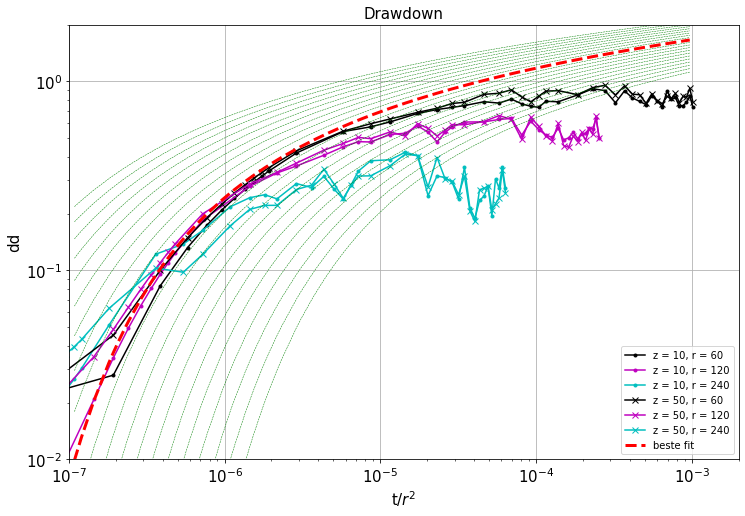

In [587]:
ax = newfig("Drawdown", r"t/$r^2$", "dd", xscale='log', yscale='log', xlim=(1e-7, 2e-3), ylim=(1e-2, 2))
for iz, z_ in enumerate(z[:, 0]):
    ls = ['.-','x-',':',';'][iz % 4]
    for ir, r_ in enumerate(r[0]):
        if r_ >= 60:
            clr = 'brgkmcy'[ir % 7]        
            ax.plot(t / r_ ** 2, dd[:, iz, ir], ls, color=clr, label='z = {:.0f}, r = {:.4g}'.format(z_, r_))

tr2 = (t[:, np.newaxis] / r[0][np.newaxis, :] ** 2).ravel()
tr2.sort()
tr2 = tr2[np.logical_and(tr2>1e-7, tr2<1e-3)]

for i, Stry in enumerate(np.logspace(-4, -2, 21)):
    if i == 9:
        clr, lw, label = 'r', 3, 'beste fit'
        print("Stry[{}]={:.4g}".format(i, Stry))
    else:
        clr, lw, label = 'g', 0.5, ""
    ax.plot(tr2, 0.212 * W(Stry/3600 / tr2), '--', color=clr, lw=lw, label=label)
ax.legend(loc='lower right')


# Best fit with S=0.008 and kD=900 now with Hantush

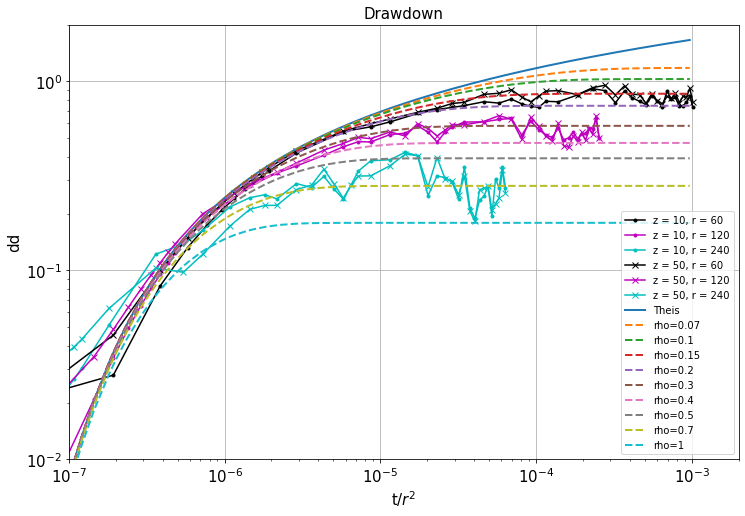

In [598]:
ax = newfig("Drawdown", r"t/$r^2$", "dd", xscale='log', yscale='log', xlim=(1e-7, 2e-3), ylim=(1e-2, 2))
for iz, z_ in enumerate(z[:, 0]):
    ls = ['.-','x-',':',';'][iz % 4]
    for ir, r_ in enumerate(r[0]):
        if r_ >= 60:
            clr = 'brgkmcy'[ir % 7]        
            ax.plot(t / r_ ** 2, dd[:, iz, ir], ls, color=clr, label='z = {:.0f}, r = {:.4g}'.format(z_, r_))

tr2 = (t[:, np.newaxis] / r[0][np.newaxis, :] ** 2).ravel()
tr2.sort()
tr2 = tr2[np.logical_and(tr2>1e-7, tr2<1e-3)]

rhos = np.array([0.07, 0.1, 0.15, 0.2,  0.3,  0.4,  0.5,  0.7, 1])
Stry = np.logspace(-4, -2, 21)[9]
ax.plot(tr2, 0.212 * Wh(Stry/3600 / tr2, 0), '-', lw=2, label="Theis")
for rho in rhos:
    ax.plot(tr2, 0.212 * Wh(Stry/3600 / tr2, rho), '--', lw=2, label="rho={:.4g}".format(rho))
ax.legend(loc='lower right')


In [494]:
matchp1 = (1.37e-5, 1.37e-1)
matchp2 = (1e2, 1e0)

1/u = (4 kD) / S * t/r ** 2



array([5.00000000e+03, 4.20223969e+03, 3.53176369e+03, 2.96826351e+03,
       2.49467095e+03, 2.09664105e+03, 1.76211765e+03, 1.48096815e+03,
       1.24467663e+03, 1.04608591e+03, 8.79180742e+02, 7.38905642e+02,
       6.21011724e+02, 5.21928023e+02, 4.38653331e+02, 3.68665288e+02,
       3.09843981e+02, 2.60407735e+02, 2.18859144e+02, 1.83939717e+02,
       1.54591756e+02, 1.29926322e+02, 1.09196310e+02, 9.17738134e+01,
       7.71311123e+01, 6.48246843e+01, 5.44817723e+01, 4.57890932e+01,
       3.84833490e+01, 3.23432513e+01, 2.71828189e+01, 2.28457441e+01,
       1.92006585e+01, 1.61371539e+01, 1.35624377e+01, 1.13985228e+01,
       9.57986500e+00, 8.05137779e+00, 6.76676386e+00, 5.68711274e+00,
       4.77972218e+00, 4.01710765e+00, 3.37616984e+00, 2.83749498e+00,
       2.38476681e+00, 2.00427235e+00, 1.68448656e+00, 1.41572326e+00,
       1.18984170e+00, 1.00000000e+00])

In [490]:
ax1.get_position()

Bbox([[0.2, 0.2], [1.1, 1.08]])

In [491]:
bb = ax1.get_position()

In [493]:
bb.xmax
bb.ymax

1.08

In [ ]:
ax1.set_position()